# This is fruit classification project implementation #1

*** Part 1 : Exploration and Visualization of Data ***

*We will begin importing important libraries*

In [1]:
import cv2
import glob
import os
import numpy as np # linear algebra
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import random
import tensorflow as tf


Using TensorFlow backend.


*We will make sure we have our input sets loaded*

In [2]:
os.chdir("../input/")

!ls

fruits	realtestdata


In [3]:
train_data_dir = '../input/fruits/fruits-360_dataset/fruits-360/Training/'
test_data_dir = '../input/fruits/fruits-360_dataset/fruits-360/Test/'

In [4]:
# this function used to read and image with specified color mode and normalize each pixel to 0-1 range
def read_and_preprocess_img(image_path,img_color,img_size):
    image = cv2.imread(image_path,cv2.IMREAD_COLOR)
    if(img_color == "RGB"):
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    elif(img_color == "Gray"):
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    imResize = cv2.resize(image, dsize=img_size) 
    return imResize.astype("float32")/255

In [5]:
# Read Images from a path given size and color mode, return array of np arrays that represents images, and it's labesl
# labels is specified by subdirectories names
def read_data(path,img_color,img_size):
    data_fruit_img = []
    data_label = []
    for dir_path in glob.glob(path+"/*"):
        img_label = dir_path.split("/")[-1]
        for image_path in glob.glob(os.path.join(dir_path,"*.jpg")):
            image = read_and_preprocess_img(image_path,img_color,img_size)
            data_fruit_img.append(image)
            data_label.append(img_label)
    return (np.array(data_fruit_img),np.array(data_label))

In [6]:
# Read Training data
#this part is considered redundant since we are using ImageDataGenerator for reading data
# but keeping our data in array with corresponding labels is a bit easier in access than DataGenerator class
X_train,train_label = read_data(train_data_dir,"RGB",(100,100))
print(X_train.shape)
print(train_label.shape)

(41322, 100, 100, 3)
(41322,)


(100, 100, 3)


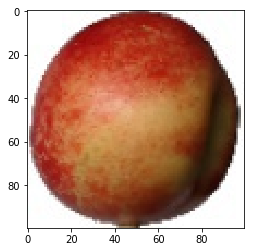

In [7]:
print(X_train[2].shape)
plt.imshow(X_train[2])
plt.show()

In [8]:
# Visualized Array of Images in a grid like plot, given its #of colomns and rows and Figure sizes.
def plot_image_grid(images, nb_rows, nb_cols, figsize=(20, 20)):
    assert len(images) == nb_rows*nb_cols, "Number of images should be the same as (nb_rows*nb_cols)"
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].axis('off')
            axs[i, j].imshow(images[n])
            n += 1

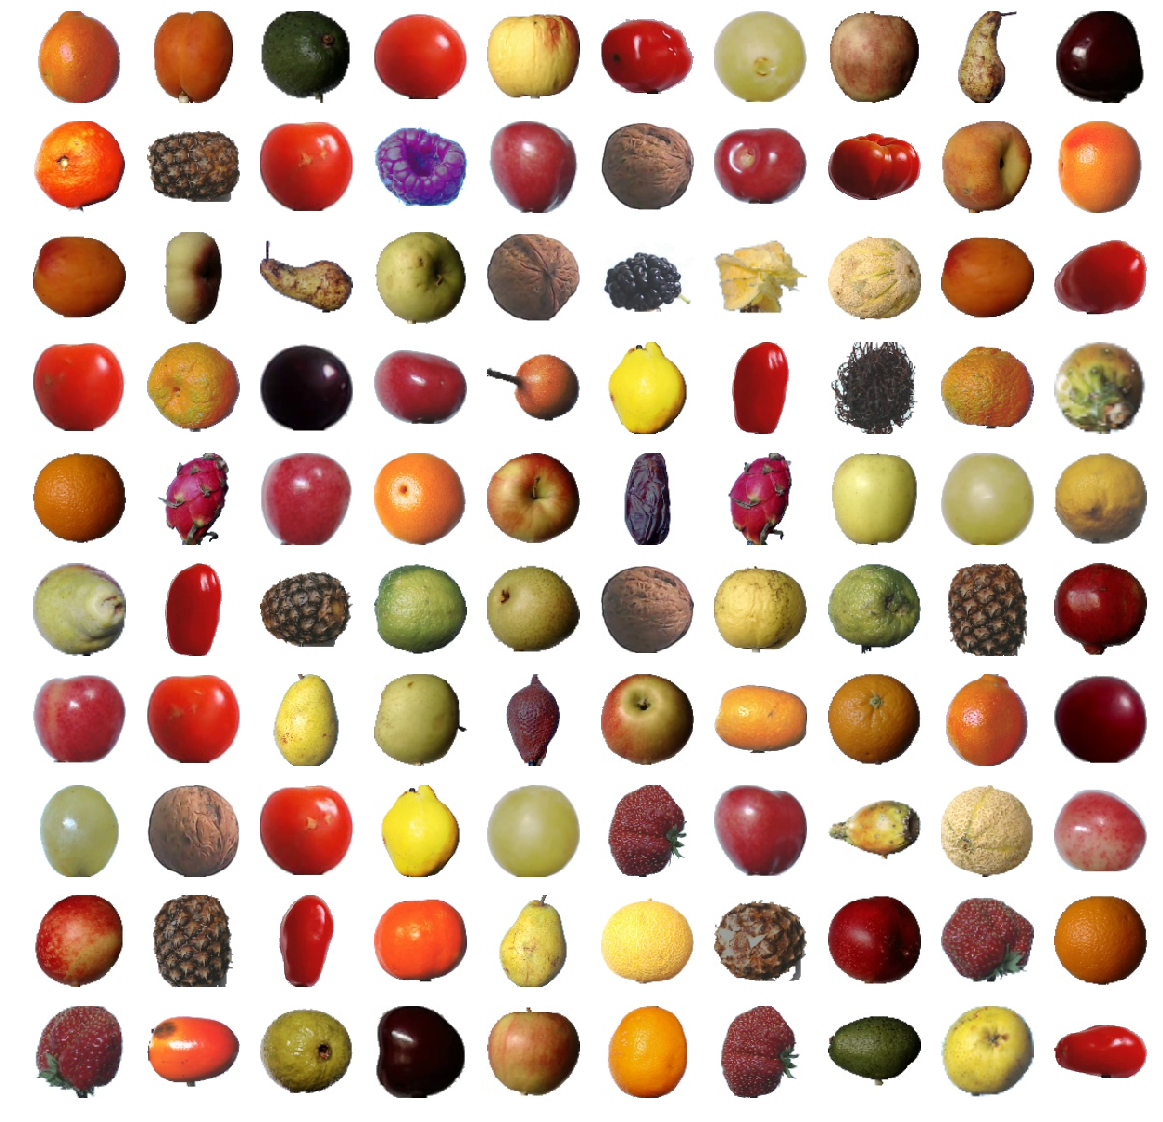

In [9]:
random_sample = random.sample(list(X_train),  100)
plot_image_grid(random_sample, 10, 10)

*We will use ImageDataGenerator Api to read data and pass it to the model later*

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split = .25
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (100,100),
    #batch_size=batch_size_train,
    class_mode='categorical',
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (100,100),
    #batch_size=batch_size_valid,#default is 32
    class_mode='categorical',
    subset='validation'
)
test_generator = test_datagen.flow_from_directory(
    directory=test_data_dir,
    target_size=(100, 100),
    batch_size=1,
    shuffle = False,
)

Found 31018 images belonging to 81 classes.
Found 10304 images belonging to 81 classes.
Found 13877 images belonging to 81 classes.


*This Part is used mainly to accumulate number of pics for each class labels in the training set*

In [11]:
training_data = pd.DataFrame(train_generator.classes, columns=['classes'])

In [12]:
# return index of the class along with number of images in that class
def create_stack_bar_data(col, df):
    aggregated = df[col].value_counts().sort_index()
    x_values = aggregated.index.tolist()
    y_values = aggregated.values.tolist()
    return x_values, y_values

In [13]:
x1, y1 = create_stack_bar_data('classes', training_data)
# get corresponding classes label using it's indices
x1 = list(train_generator.class_indices.keys())

<BarContainer object of 81 artists>

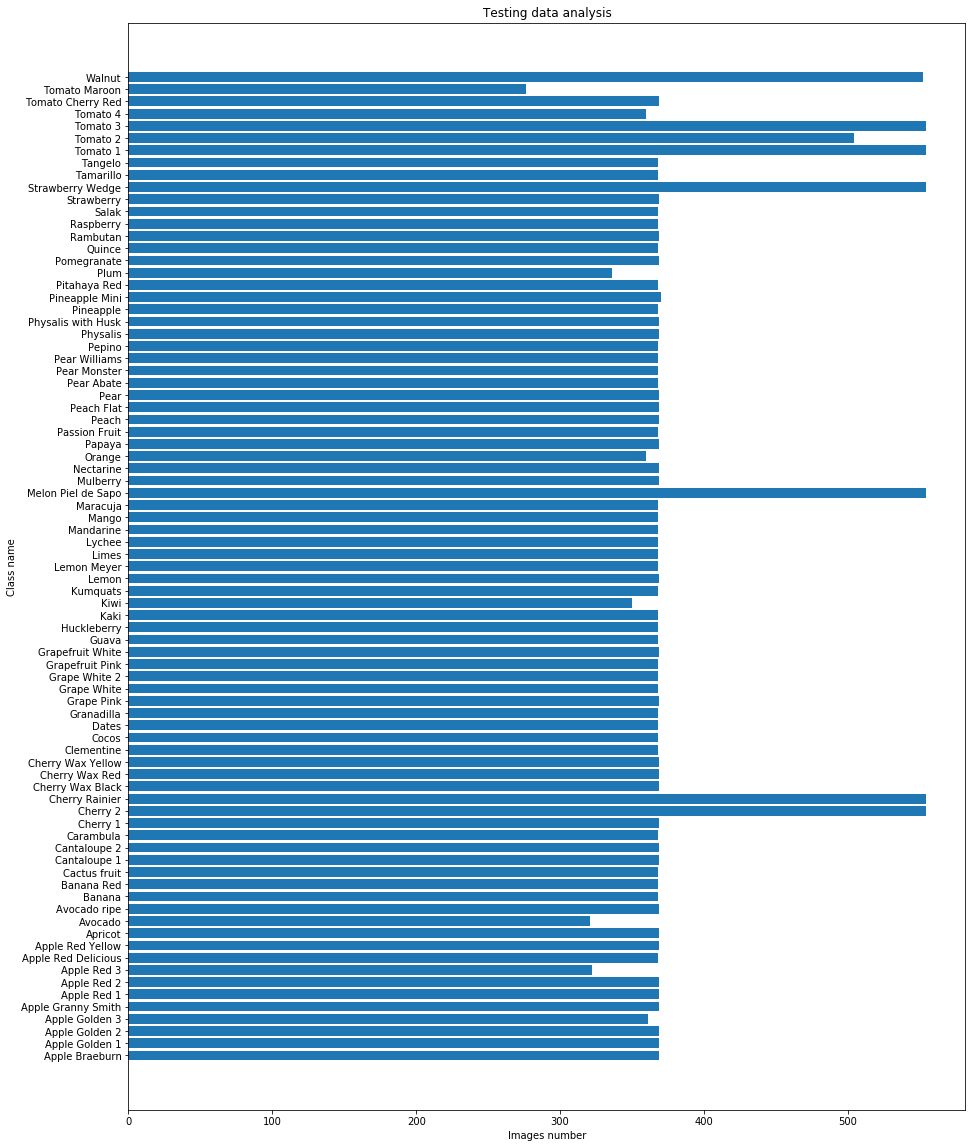

In [14]:
# finally plotting the results
fig, ax = plt.subplots(figsize=(15, 20))
ax.set( xlabel='Images number', ylabel='Class name',
       title='Testing data analysis')
ax.barh(x1, y1)

** Part 2: Building and Testing model on the regular Test set **

In [15]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

In [16]:
model = Sequential()
### TODO: Define your architecture.
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=train_generator.image_shape))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(81, activation='softmax'))
        
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 49, 49, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

In [17]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

*Create directory where we will save models weights*

In [18]:
from os.path import join, exists, expanduser
models_dir = expanduser(join('~', 'saved_models'))
if not exists(models_dir):
    os.makedirs(models_dir)

In [19]:
# making sure it's created successfully
!ls ~

saved_models


In [20]:
from keras.callbacks import ModelCheckpoint,EarlyStopping  

#Early stopping
early_stopping = EarlyStopping(monitor='val_acc', verbose=1, patience=4)

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 50

checkpointer = ModelCheckpoint(filepath='/tmp/saved_models/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)
with tf.device("/device:GPU:0"):
    history = model.fit_generator(
            train_generator,
            steps_per_epoch=train_generator.samples // train_generator.batch_size,
            epochs=epochs,
            callbacks=[checkpointer,early_stopping],
            verbose=1,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // validation_generator.batch_size)

Epoch 1/50
969/969 [==============================] - 49s 50ms/step - loss: 2.3150 - acc: 0.3752 - val_loss: 1.3405 - val_acc: 0.6195

Epoch 00001: val_loss improved from inf to 1.34045, saving model to /tmp/saved_models/weights.best.basic_cnn.hdf5
Epoch 2/50
969/969 [==============================] - 47s 49ms/step - loss: 0.8670 - acc: 0.7386 - val_loss: 0.8224 - val_acc: 0.8013

Epoch 00002: val_loss improved from 1.34045 to 0.82242, saving model to /tmp/saved_models/weights.best.basic_cnn.hdf5
Epoch 3/50
969/969 [==============================] - 48s 49ms/step - loss: 0.5638 - acc: 0.8271 - val_loss: 0.6400 - val_acc: 0.8485

Epoch 00003: val_loss improved from 0.82242 to 0.64000, saving model to /tmp/saved_models/weights.best.basic_cnn.hdf5
Epoch 4/50
969/969 [==============================] - 47s 48ms/step - loss: 0.4050 - acc: 0.8715 - val_loss: 0.6237 - val_acc: 0.8356

Epoch 00004: val_loss improved from 0.64000 to 0.62372, saving model to /tmp/saved_models/weights.best.basic_c

In [21]:
model.load_weights("/tmp/saved_models/weights.best.basic_cnn.hdf5")

In [22]:
model.evaluate_generator(test_generator, test_generator.samples)

[0.1744300154834811, 0.9424947755278519]

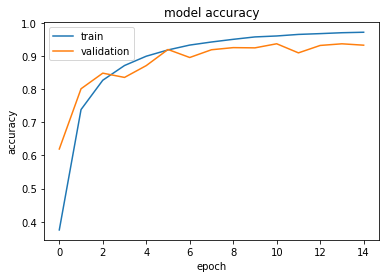

In [23]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

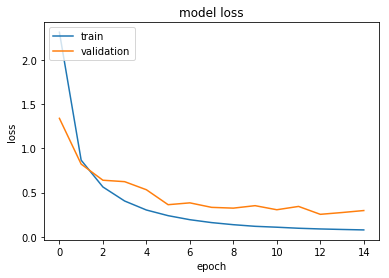

In [24]:

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Part3: Testing model with real data set**

In [25]:
# given fruit class name, get a sample image from it's directory
def get_specific_class_img (class_name):
    root_directory = '../input/fruits/fruits-360_dataset/fruits-360/Training/'+ class_name + '/'
    img_path = glob.glob(os.path.join(root_directory,"*.jpg"))[0]
    return read_and_preprocess_img(img_path,"RGB",(100,100))

In [26]:
# given an image get it's predicted class label
def model_predict(img):
    # obtain predicted vector
    predicted_vector = model.predict(img)
    # return fruit class that is predicted by the model
    return x1[np.argmax(predicted_vector)]

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


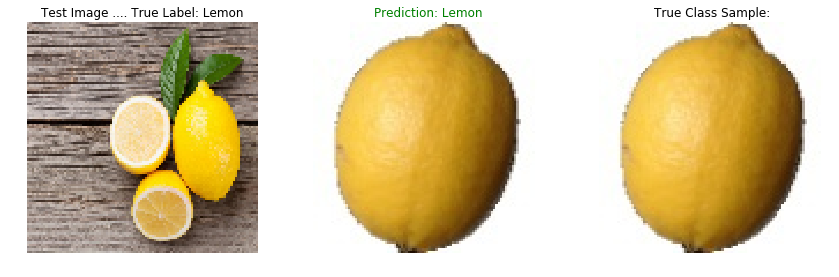

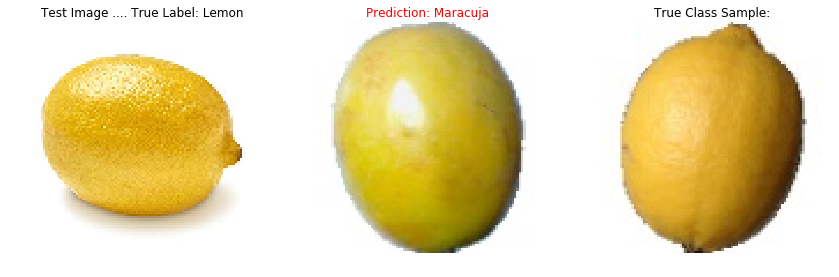

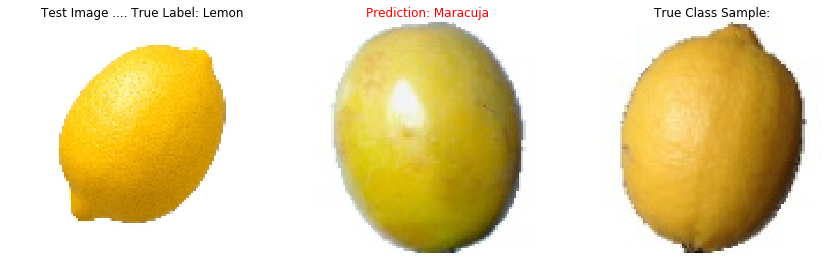

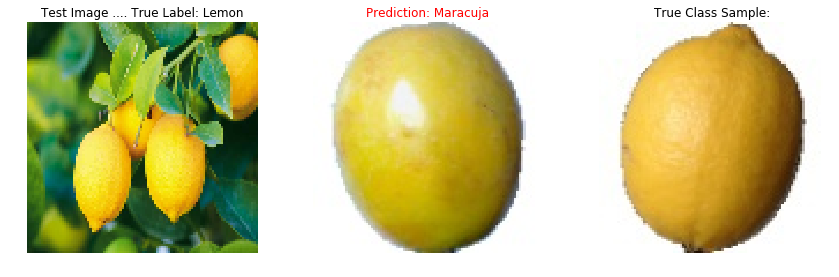

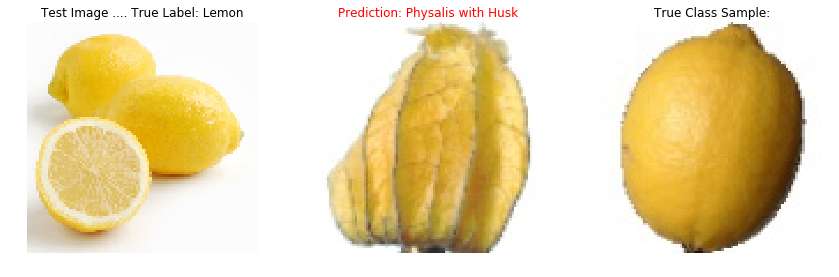

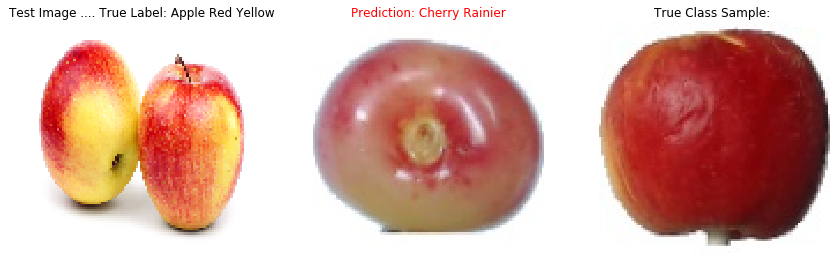

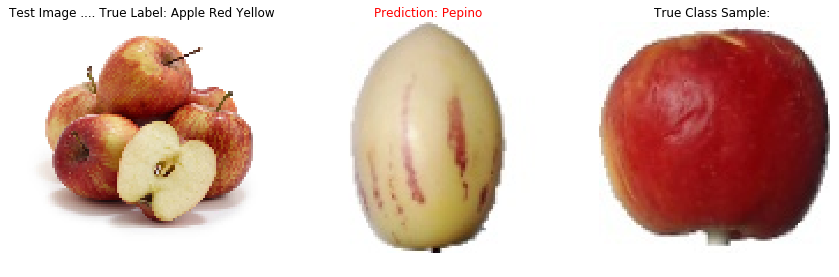

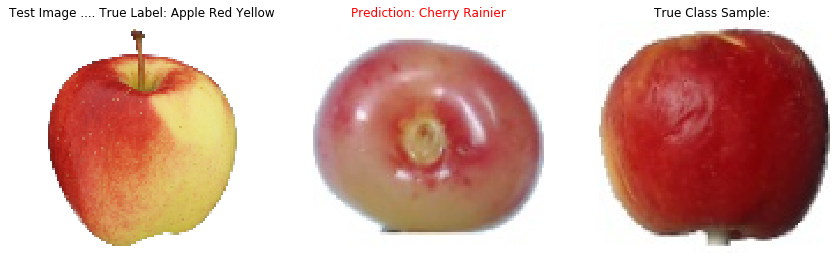

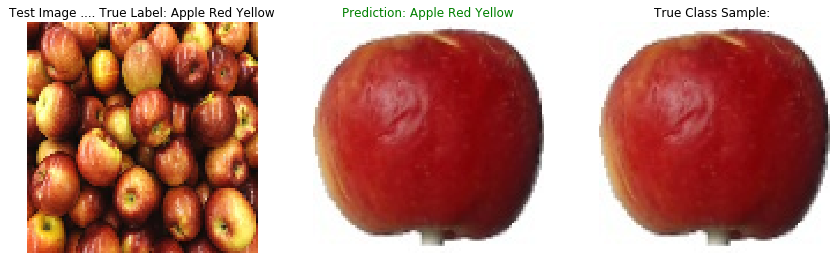

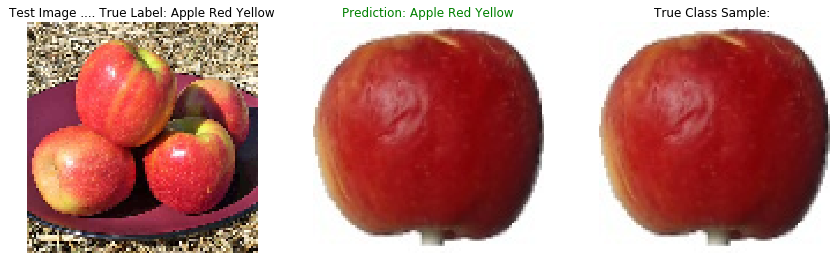

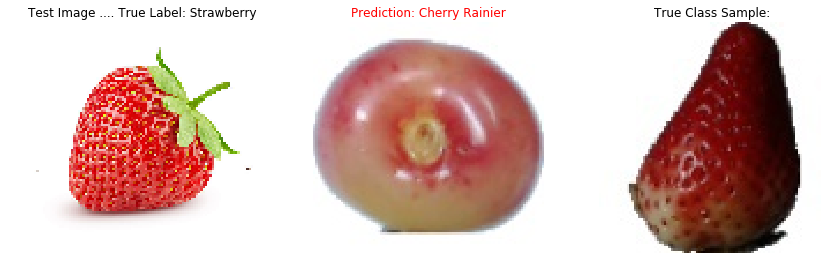

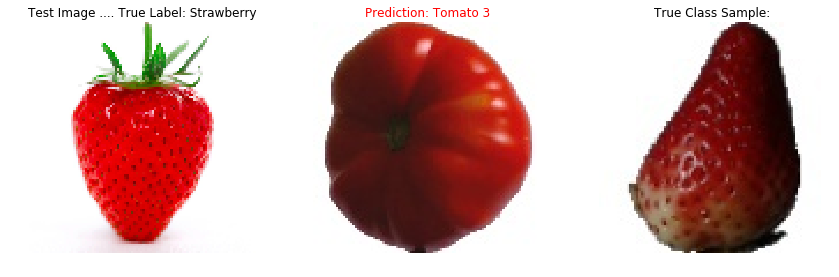

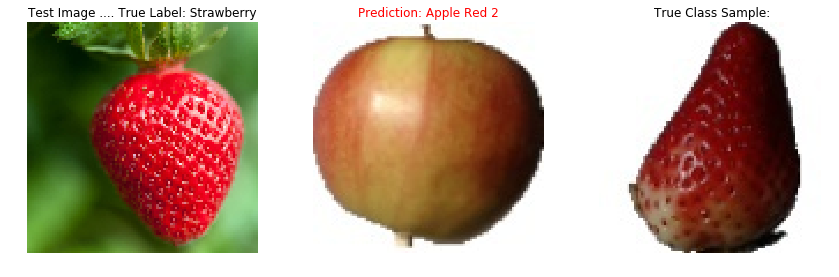

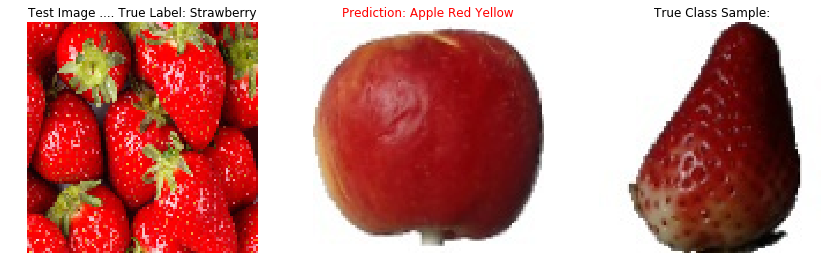

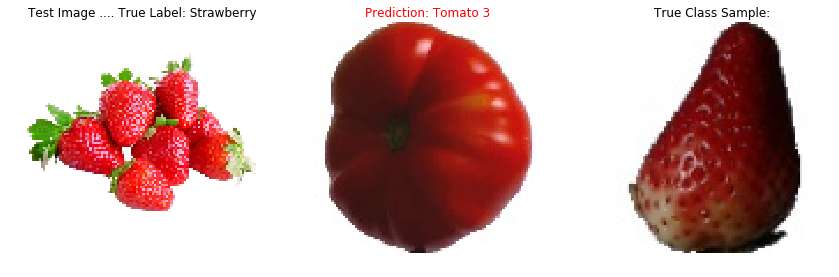

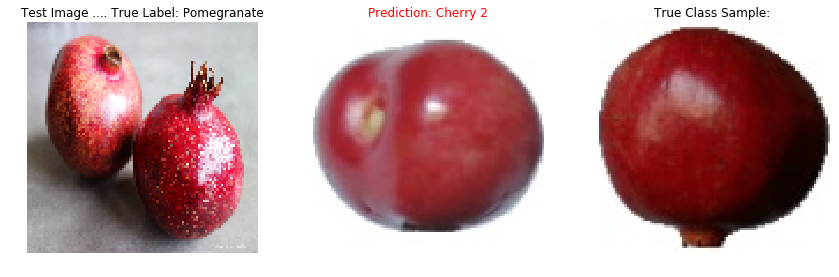

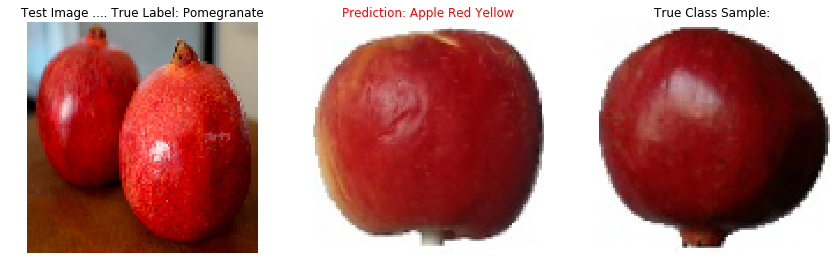

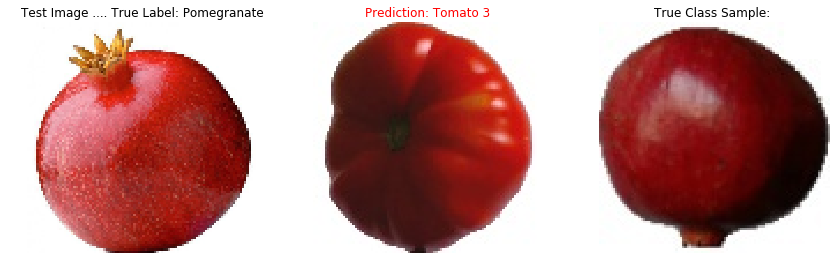

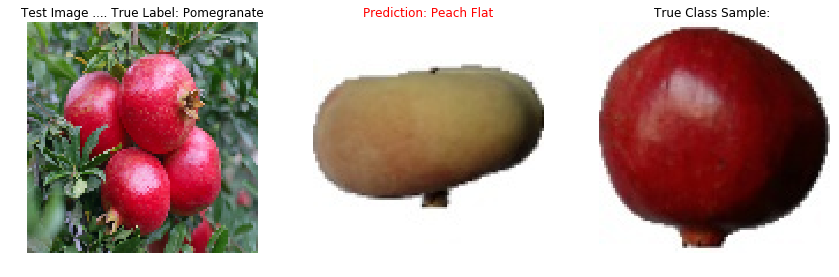

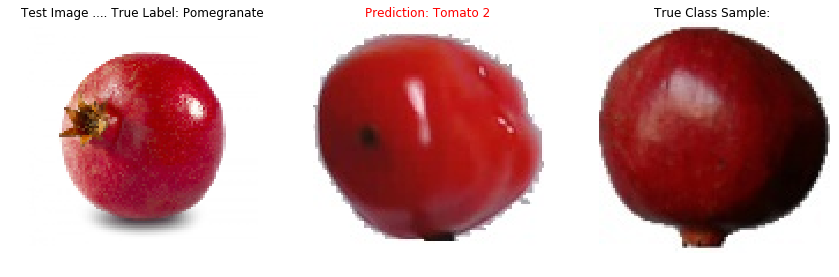

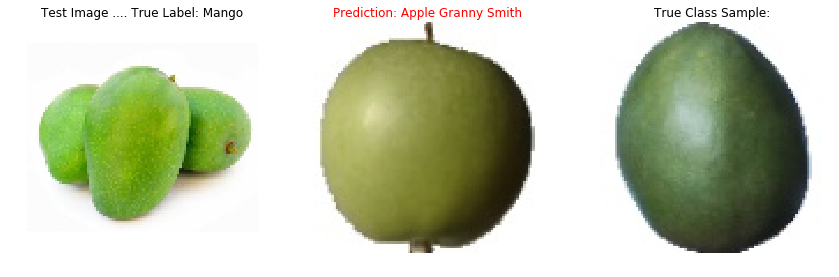

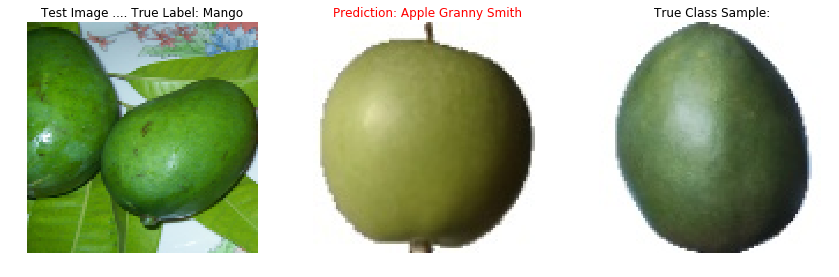

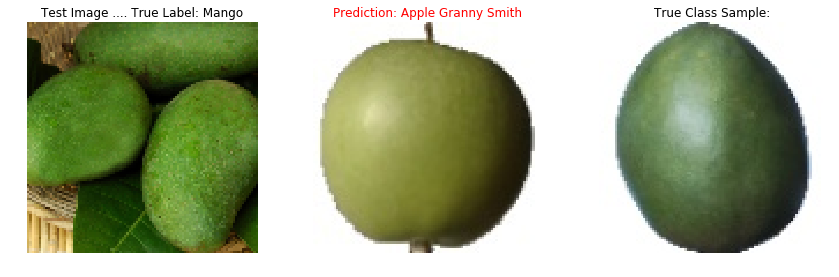

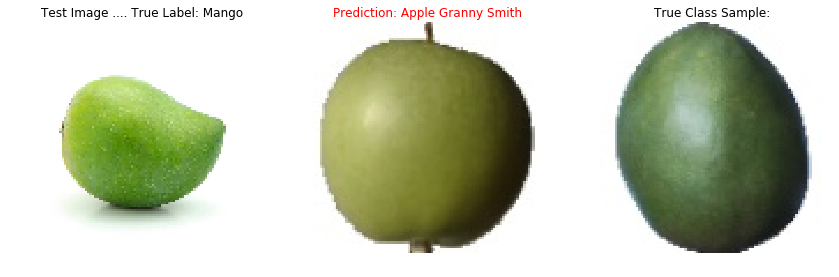

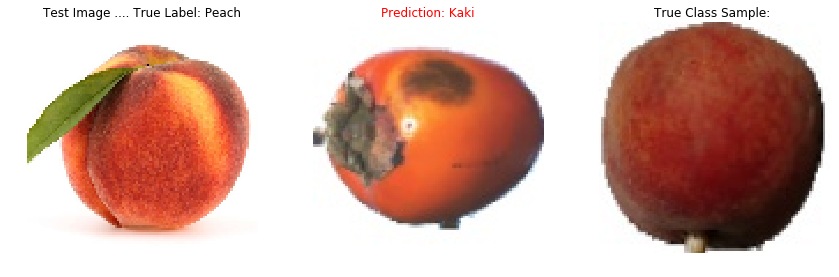

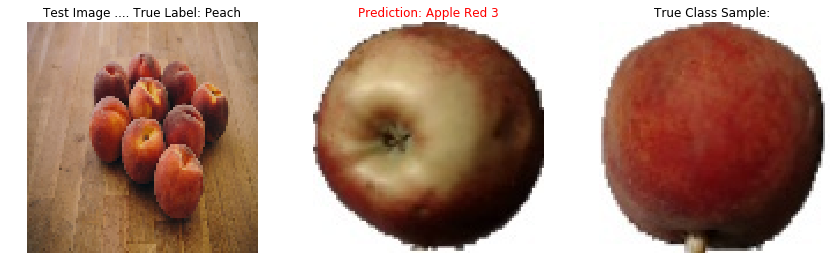

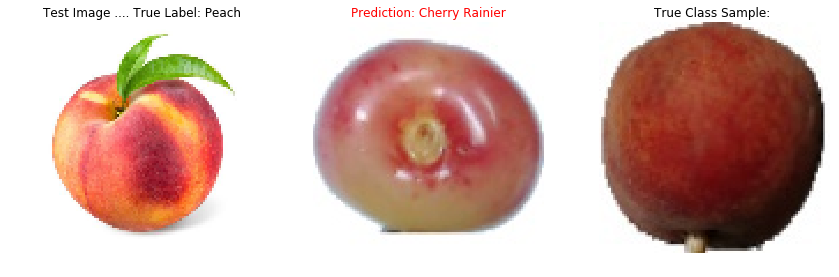

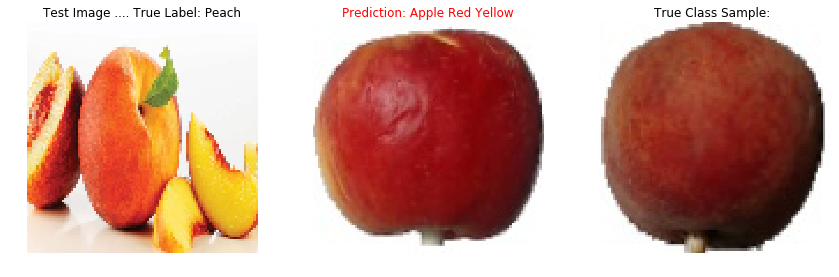

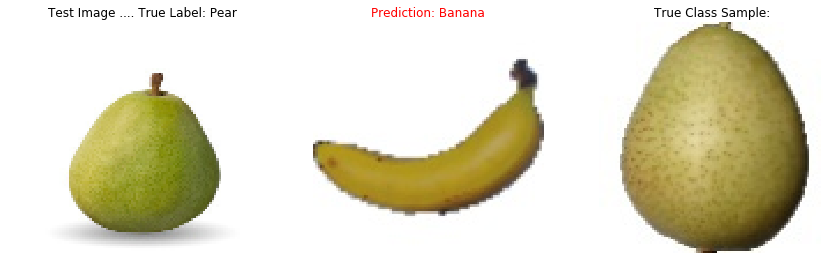

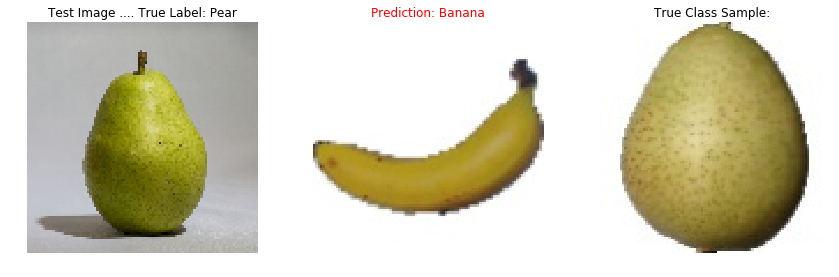

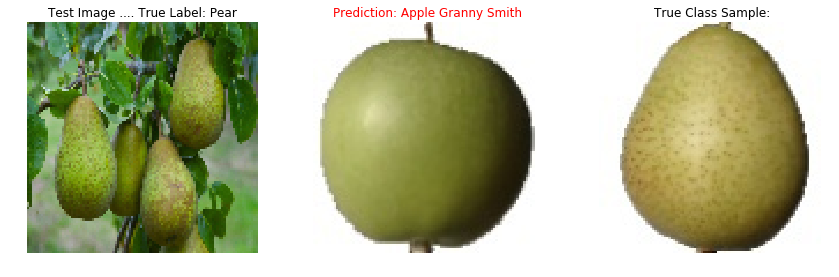

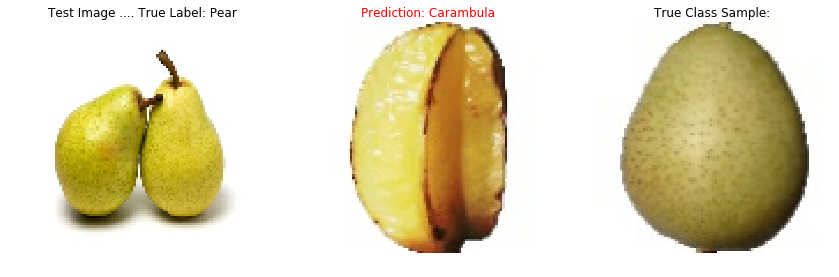

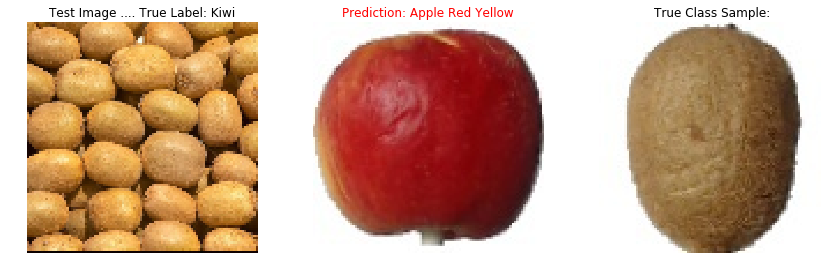

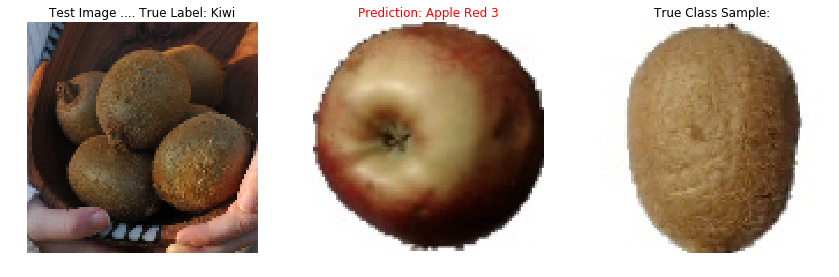

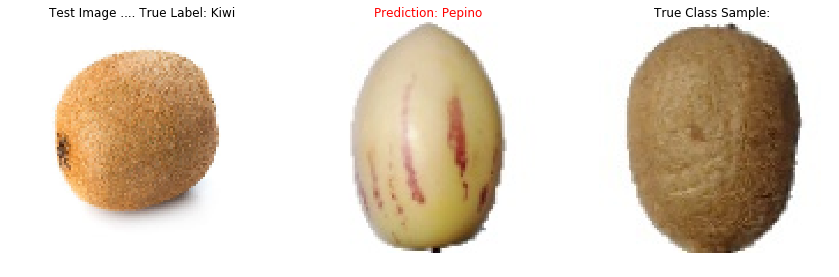

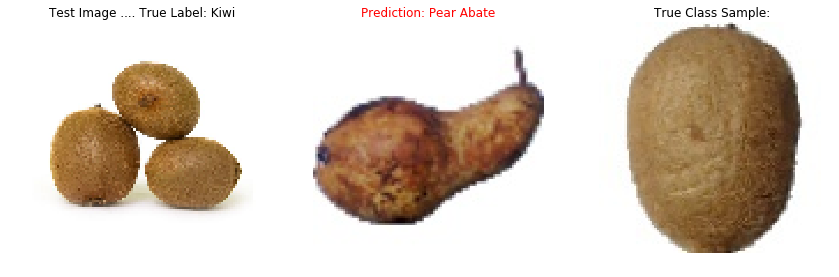

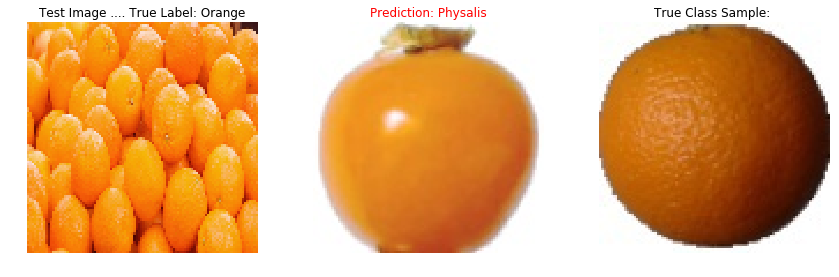

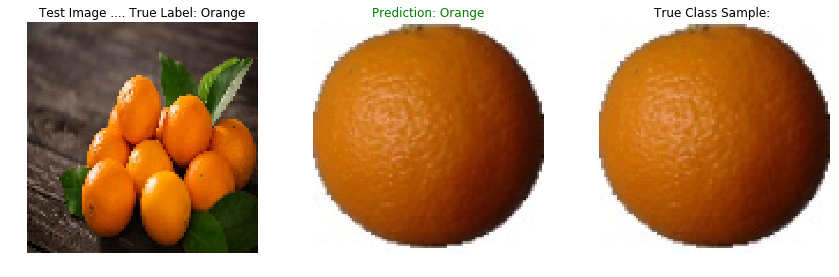

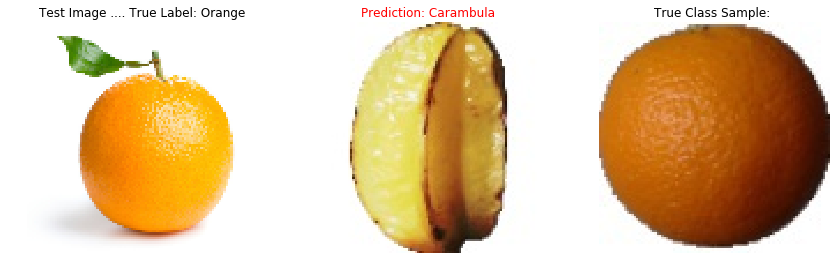

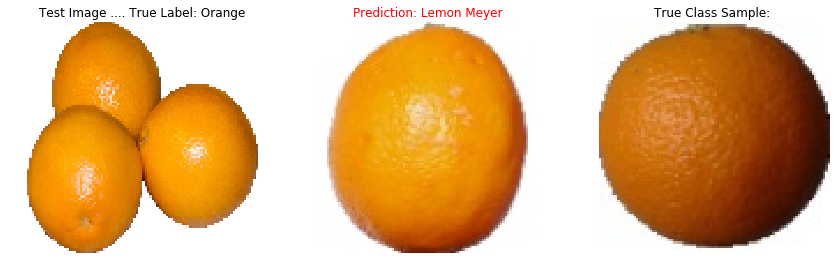

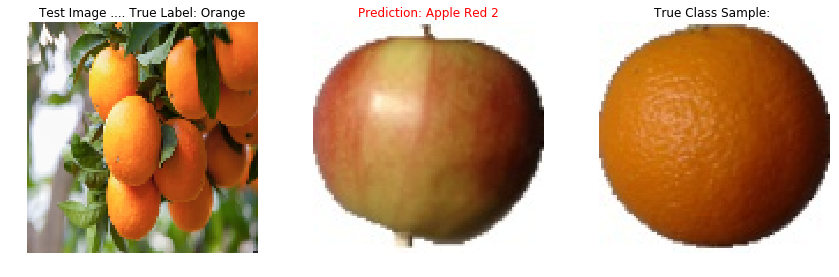

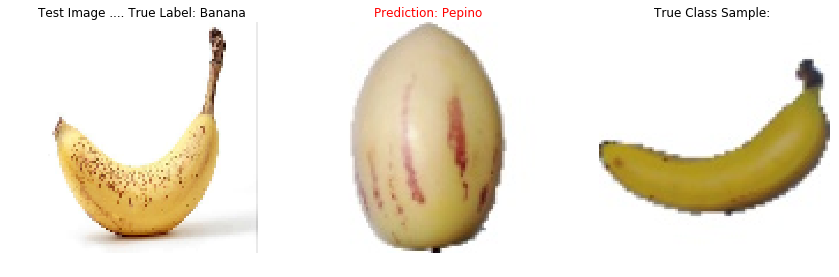

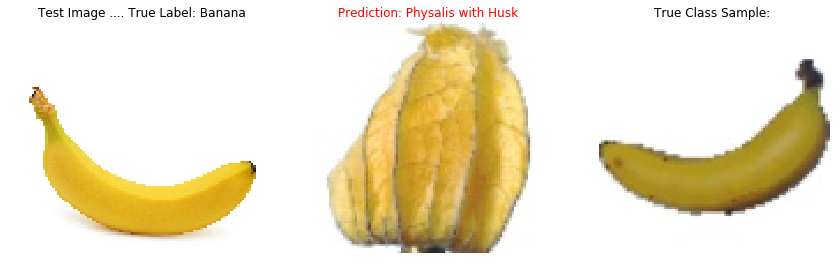

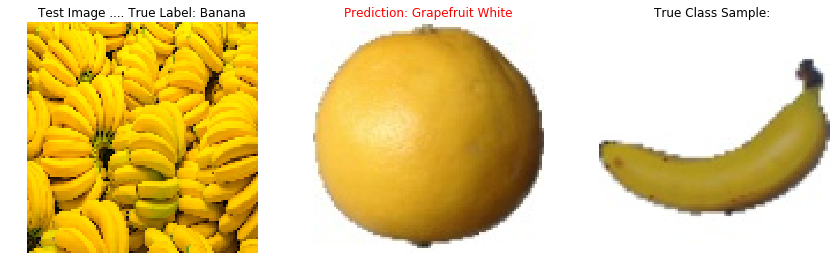

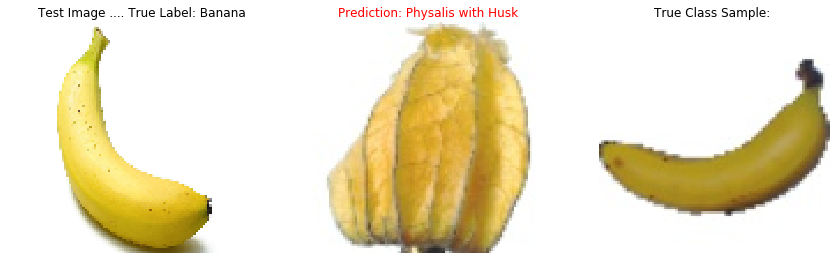

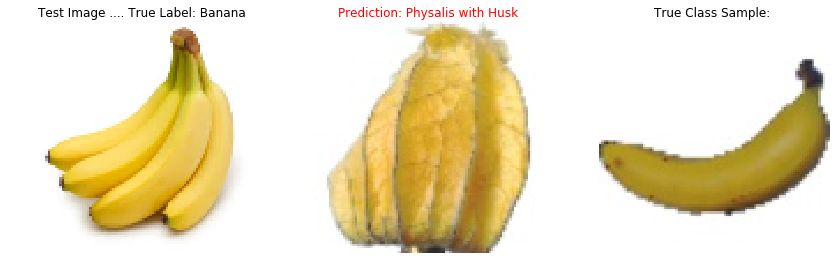

In [27]:
import os
unseen_test_data_dir = '../input/realtestdata/real-data/Capstone Data/'
right_pred = 0
#unseen_test_data_dir = '../input/fruits/fruits-360_dataset/fruits-360/Test/'
X_real_test,test_label = read_data(unseen_test_data_dir,"RGB",(100,100))
for i,img in enumerate(X_real_test):
    pred_class_name = model_predict(np.expand_dims(img, axis=0))
    true_label = test_label[i]
    pred_right = (true_label == pred_class_name)
    if pred_right:
        right_pred += 1
    f, (ax1,ax2,ax3) = plt.subplots(1,3)
    plt.subplots_adjust(bottom=0.1, right=2, top=0.9)
    ax1.imshow(img)
    ax1.set_axis_off()    
    ax1.set_title('Test Image .... True Label: '+ true_label)
    ax2.imshow(get_specific_class_img(pred_class_name))
    ax2.set_axis_off()
    ax2.set_title('Prediction: '+ pred_class_name,color=("green" if pred_right else "red"))
    ax3.imshow(get_specific_class_img(true_label))
    ax3.set_axis_off()
    ax3.set_title('True Class Sample: ')

In [28]:
print("Basic Model predicted {} images right,accuracy = {}%".format(right_pred,(right_pred*100./50)))

Basic Model predicted 4 images right,accuracy = 8.0%
